In [1]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import geopy.distance as distance
import rioxarray
from multiprocessing import Pool, Manager

%matplotlib inline

In [2]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [3]:
metadata = pd.read_csv('../data/metadata.csv')

In [4]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]

In [5]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%d"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


In [6]:
example_row = metadata[metadata.uid == "garm"].iloc[0]
example_row

uid                garm
latitude       41.98006
longitude    -110.65734
date         2021-09-27
split             train
Name: 5461, dtype: object

In [7]:
bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=3000)
bbox

[-110.69353838433213,
 41.953050646872555,
 -110.62114161566788,
 42.00706922560391]

In [8]:
date_range = get_date_range(example_row.date, 15)
date_range

'2021-09-12/2021-09-27'

In [9]:
# search the planetary computer sentinel-l2a
search = catalog.search(
    collections=["sentinel-2-l2a"], bbox=bbox, datetime=date_range
)

# see how many items were returned
items = [item for item in search.item_collection()]
len(items)

3

In [10]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < example_row.latitude)
    & (item_details.max_lat > example_row.latitude)
    & (item_details.min_long < example_row.longitude)
    & (item_details.max_long > example_row.longitude)
)

print(
    f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
)

item_details = item_details[item_details["contains_sample_point"]]
item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
    by="datetime"
)

Filtering from 3 returned to 3 items that contain the sample location


,datetime,platform,contains_sample_point,bbox
2,2021-09-14,Sentinel-2A,True,"[-111.000244, 41.45624189757688, -109.665115, ..."
1,2021-09-19,Sentinel-2B,True,"[-111.000244, 41.45624189757688, -109.665115, ..."
0,2021-09-24,Sentinel-2A,True,"[-111.000244, 41.4562419, -109.665115, 42.4526..."


In [11]:
# 1 - filter to sentinel
item_details[item_details.platform.str.contains("Sentinel")]

,datetime,platform,min_long,max_long,min_lat,max_lat,bbox,item_obj,contains_sample_point
0,2021-09-24,Sentinel-2A,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.4562419, -109.665115, 42.4526...",<Item id=S2A_MSIL2A_20210924T181101_R084_T12TW...,True
1,2021-09-19,Sentinel-2B,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.45624189757688, -109.665115, ...",<Item id=S2B_MSIL2A_20210919T180919_R084_T12TW...,True
2,2021-09-14,Sentinel-2A,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.45624189757688, -109.665115, ...",<Item id=S2A_MSIL2A_20210914T180951_R084_T12TW...,True


In [12]:
# 2 - take closest by date
best_item = (
    item_details[item_details.platform.str.contains("Sentinel")]
    .sort_values(by="datetime", ascending=False)
    .iloc[0]
)
best_item

datetime                                                        2021-09-24
platform                                                       Sentinel-2A
min_long                                                       -111.000244
max_long                                                       -109.665115
min_lat                                                          41.456242
max_lat                                                          42.452691
bbox                     [-111.000244, 41.4562419, -109.665115, 42.4526...
item_obj                 <Item id=S2A_MSIL2A_20210924T181101_R084_T12TW...
contains_sample_point                                                 True
Name: 0, dtype: object

In [13]:
item = best_item.item_obj

In [14]:
# What assets are available?
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

In [15]:
def crop_sentinel_image(item, bounding_box, band):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = rioxarray.open_rasterio(pc.sign(item.assets[band].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

In [16]:
%%time

minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=3000
)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)

true_color = crop_sentinel_image(item, bbox, "visual")
scl = crop_sentinel_image(item, bbox, "SCL")[0]

CPU times: user 67.4 ms, sys: 29.8 ms, total: 97.2 ms
Wall time: 9.73 s


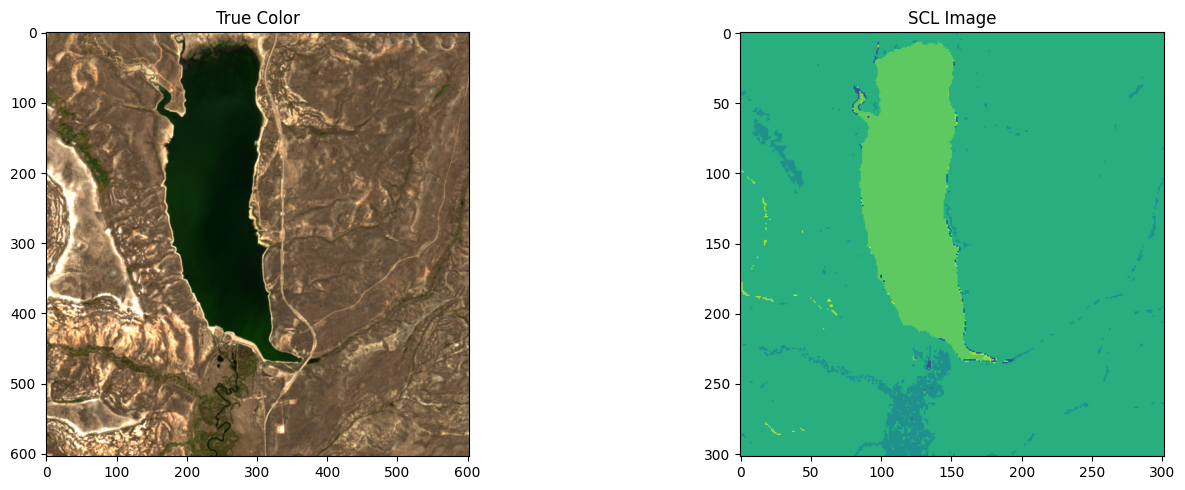

In [17]:
# Crear subplots con una fila y tres columnas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Mostrar la primera imagen en el primer subplot
axs[0].imshow(np.transpose(true_color, axes=[1, 2, 0]))
axs[0].set_title('True Color')

# Mostrar la segunda imagen en el tercer subplot
axs[1].imshow(scl)
axs[1].set_title('SCL Image')

# Ajustar diseño
plt.tight_layout()
# Mostrar los subplots
plt.show()

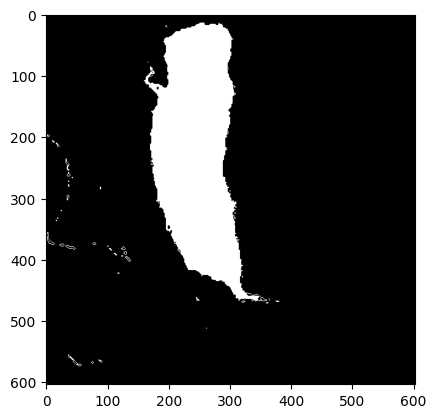

In [18]:
visual = np.transpose(true_color, axes=[1, 2, 0])
water_mask = np.stack([cv2.resize(scl, (visual.shape[1], visual.shape[0]))] * 3, -1) == 6
water_mask = np.where(water_mask, 255, 0)
plt.imshow(water_mask)

In [19]:
# Get images
def get_images(row):
    """
    Given a row from the metadada, return 2 cropped images from sentinel
    1. True color image
    2. Water mask
    """
    bbox = get_bounding_box(row.latitude, row.longitude, meter_buffer=3000)
    date_range = get_date_range(row.date)
    
    # search the planetary computer sentinel-l2a
    search = catalog.search(
        collections=["sentinel-2-l2a"], 
        bbox=bbox, 
        datetime=date_range
    )
    
    # get items
    items = [item for item in search.item_collection()]
    
    # get details of all of the items returned
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "bbox": item.bbox,
                "item_obj": item,
            }
            for item in items
        ]
    )
    
    # check which rows actually contain the sample location
    item_details["contains_sample_point"] = (
        (item_details.min_lat < row.latitude)
        & (item_details.max_lat > row.latitude)
        & (item_details.min_long < row.longitude)
        & (item_details.max_long > row.longitude)
    )
    item_details = item_details[item_details["contains_sample_point"]]
    item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
        by="datetime"
    )
    
    #Get best item
    best_item = (
    item_details[item_details.platform.str.contains("Sentinel")]
    .sort_values(by="datetime", ascending=False)
    .iloc[0]
    )
    item = best_item.item_obj

    bbox = get_bounding_box(row.latitude, row.longitude, meter_buffer=1000)
    true_color = crop_sentinel_image(item, bbox, "visual")
    scl = crop_sentinel_image(item, bbox, "SCL")[0]
    
    # transpose
    visual = np.transpose(true_color, axes=[1, 2, 0])
    water_mask = np.stack([cv2.resize(scl, (visual.shape[1], visual.shape[0]))] * 3, -1) == 6
    water_mask = np.where(water_mask, 1, np.nan)
    water_mask = np.mean(water_mask, axis=2, keepdims=True)
    
    # Return images
    return visual, water_mask

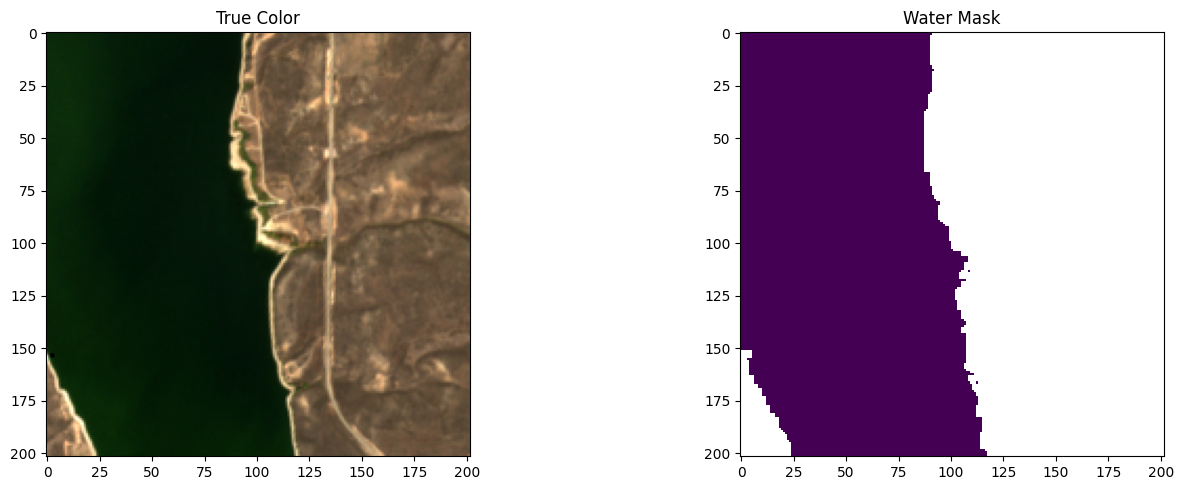

CPU times: user 283 ms, sys: 192 ms, total: 475 ms
Wall time: 2.42 s


In [20]:
%%time 

test_visual, test_water_mask = get_images(example_row)

# Crear subplots con una fila y tres columnas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Mostrar la primera imagen en el primer subplot
axs[0].imshow(test_visual)
axs[0].set_title('True Color')

# Mostrar la segunda imagen en el tercer subplot
axs[1].imshow(test_water_mask)
axs[1].set_title('Water Mask')

# Ajustar diseño
plt.tight_layout()
# Mostrar los subplots
plt.show()

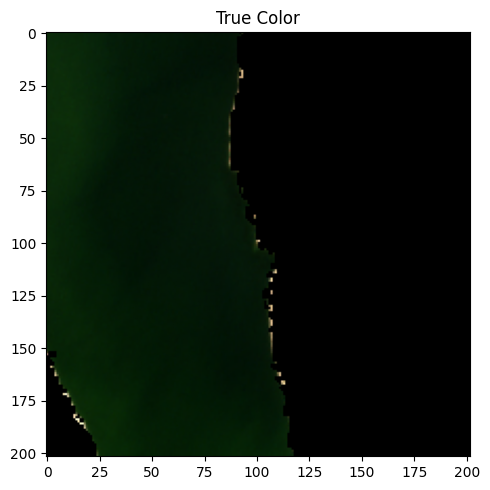

In [21]:
test_visual, test_water_mask = get_images(example_row)

test_visual = test_visual * test_water_mask

test_visual_rep = np.nan_to_num(test_visual, nan=0)
test_visual_rep = test_visual_rep / np.nanmax(test_visual_rep)

# Crear subplots con una fila y tres columnas
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

# Mostrar la primera imagen en el primer subplot
plt.imshow(test_visual_rep)
plt.title('True Color')

# Ajustar diseño
plt.tight_layout()
# Mostrar los subplots
plt.show()

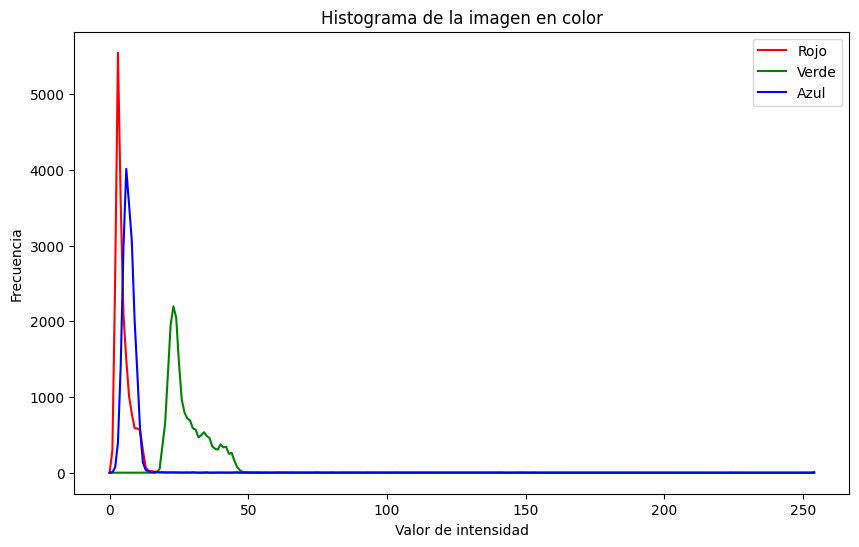

In [22]:
red_values = test_visual[:,:,0].flatten()
green_values = test_visual[:,:,1].flatten()
blue_values = test_visual[:,:,2].flatten()

# Calcular los histogramas de cada banda de color
red_hist, red_bins = np.histogram(red_values, bins=255, range=(0, 255))
green_hist, green_bins = np.histogram(green_values, bins=255, range=(0, 255))
blue_hist, blue_bins = np.histogram(blue_values, bins=255, range=(0, 255))

# Graficar los histogramas
plt.figure(figsize=(10, 6))
plt.plot(red_bins[:-1], red_hist, color='red', label='Rojo')
plt.plot(green_bins[:-1], green_hist, color='green', label='Verde')
plt.plot(blue_bins[:-1], blue_hist, color='blue', label='Azul')
plt.title('Histograma de la imagen en color')
plt.xlabel('Valor de intensidad')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

In [23]:
means = {
    'R_mean': np.nanmean(red_values),
    'G_mean': np.nanmean(green_values),
    'B_mean': np.nanmean(blue_values),
    'R_median': np.nanmedian(red_values),
    'G_median': np.nanmedian(green_values),
    'B_median': np.nanmedian(blue_values)
}

means

{'R_mean': 5.57963300892133,
 'G_mean': 28.545417680454175,
 'B_mean': 7.410938767234388,
 'R_median': 4.0,
 'G_median': 25.0,
 'B_median': 7.0}

In [24]:
features = {'B_' + str(int(x)): 0 if np.isnan(y) else y for x, y in zip(blue_bins, blue_values)}

features

{'B_0': 9.0,
 'B_1': 8.0,
 'B_2': 12.0,
 'B_3': 10.0,
 'B_4': 12.0,
 'B_5': 11.0,
 'B_6': 10.0,
 'B_7': 10.0,
 'B_8': 10.0,
 'B_9': 11.0,
 'B_10': 7.0,
 'B_11': 11.0,
 'B_12': 12.0,
 'B_13': 12.0,
 'B_14': 13.0,
 'B_15': 9.0,
 'B_16': 8.0,
 'B_17': 7.0,
 'B_18': 12.0,
 'B_19': 9.0,
 'B_20': 11.0,
 'B_21': 9.0,
 'B_22': 10.0,
 'B_23': 9.0,
 'B_24': 11.0,
 'B_25': 9.0,
 'B_26': 8.0,
 'B_27': 10.0,
 'B_28': 9.0,
 'B_29': 9.0,
 'B_30': 9.0,
 'B_31': 10.0,
 'B_32': 10.0,
 'B_33': 9.0,
 'B_34': 9.0,
 'B_35': 9.0,
 'B_36': 8.0,
 'B_37': 7.0,
 'B_38': 9.0,
 'B_39': 12.0,
 'B_40': 8.0,
 'B_41': 7.0,
 'B_42': 7.0,
 'B_43': 6.0,
 'B_44': 7.0,
 'B_45': 7.0,
 'B_46': 6.0,
 'B_47': 8.0,
 'B_48': 8.0,
 'B_49': 7.0,
 'B_50': 8.0,
 'B_51': 8.0,
 'B_52': 7.0,
 'B_53': 6.0,
 'B_54': 8.0,
 'B_55': 7.0,
 'B_56': 7.0,
 'B_57': 7.0,
 'B_58': 6.0,
 'B_59': 5.0,
 'B_60': 4.0,
 'B_61': 6.0,
 'B_62': 10.0,
 'B_63': 8.0,
 'B_64': 5.0,
 'B_65': 6.0,
 'B_66': 6.0,
 'B_67': 6.0,
 'B_68': 6.0,
 'B_69': 7.0,
 'B_70': 

In [25]:
def get_features(row):
    visual, water_mask = get_images(row)
    visual = visual * water_mask
    red_values = visual[:,:,0].flatten()
    green_values = visual[:,:,1].flatten()
    blue_values = visual[:,:,2].flatten() 
    # Calcular los histogramas de cada banda de color
    red_hist, red_bins = np.histogram(red_values, bins=255, range=(0, 255))
    green_hist, green_bins = np.histogram(green_values, bins=255, range=(0, 255))
    blue_hist, blue_bins = np.histogram(blue_values, bins=255, range=(0, 255))
    #
    means = {
        'uid': row.uid,
        'R_mean': np.nanmean(red_values),
        'G_mean': np.nanmean(green_values),
        'B_mean': np.nanmean(blue_values),
        'R_median': np.nanmedian(red_values),
        'G_median': np.nanmedian(green_values),
        'B_median': np.nanmedian(blue_values),
        'G_vs_R': np.nanmean(green_values) / np.nanmean(red_values),
        'G_vs_B': np.nanmean(green_values) / np.nanmean(blue_values),
    }
    blue_f = {'B_' + str(int(x)): 0 if np.isnan(y) else y for x, y in zip(blue_bins, blue_values)}
    green_f = {'G_' + str(int(x)): 0 if np.isnan(y) else y for x, y in zip(green_bins, green_values)}
    red_f = {'R_' + str(int(x)): 0 if np.isnan(y) else y for x, y in zip(red_bins, red_values)}
    
    return dict(means, **blue_f, **green_f, **red_f)
    

In [26]:
test_features = get_features(example_row)

test_features

{'uid': 'garm',
 'R_mean': 5.57963300892133,
 'G_mean': 28.545417680454175,
 'B_mean': 7.410938767234388,
 'R_median': 4.0,
 'G_median': 25.0,
 'B_median': 7.0,
 'G_vs_R': 5.11600272541449,
 'G_vs_B': 3.8517951068035536,
 'B_0': 9.0,
 'B_1': 8.0,
 'B_2': 12.0,
 'B_3': 10.0,
 'B_4': 12.0,
 'B_5': 11.0,
 'B_6': 10.0,
 'B_7': 10.0,
 'B_8': 10.0,
 'B_9': 11.0,
 'B_10': 7.0,
 'B_11': 11.0,
 'B_12': 12.0,
 'B_13': 12.0,
 'B_14': 13.0,
 'B_15': 9.0,
 'B_16': 8.0,
 'B_17': 7.0,
 'B_18': 12.0,
 'B_19': 9.0,
 'B_20': 11.0,
 'B_21': 9.0,
 'B_22': 10.0,
 'B_23': 9.0,
 'B_24': 11.0,
 'B_25': 9.0,
 'B_26': 8.0,
 'B_27': 10.0,
 'B_28': 9.0,
 'B_29': 9.0,
 'B_30': 9.0,
 'B_31': 10.0,
 'B_32': 10.0,
 'B_33': 9.0,
 'B_34': 9.0,
 'B_35': 9.0,
 'B_36': 8.0,
 'B_37': 7.0,
 'B_38': 9.0,
 'B_39': 12.0,
 'B_40': 8.0,
 'B_41': 7.0,
 'B_42': 7.0,
 'B_43': 6.0,
 'B_44': 7.0,
 'B_45': 7.0,
 'B_46': 6.0,
 'B_47': 8.0,
 'B_48': 8.0,
 'B_49': 7.0,
 'B_50': 8.0,
 'B_51': 8.0,
 'B_52': 7.0,
 'B_53': 6.0,
 'B_54': 8.0,

In [27]:
def get_valid_data_points(row, valid_points):
    """
    Given a row from the metadada, return true if data can be extracted from data point
    """
    try:
        bbox = get_bounding_box(row.latitude, row.longitude, meter_buffer=100)
        date_range = get_date_range(row.date)
        # search the planetary computer sentinel-l2a and landsat level-2 collections
        search = catalog.search(
            collections=["sentinel-2-l2a"], 
            bbox=bbox, 
            datetime=date_range
        )
        # get items
        items = [item for item in search.item_collection()]
        item_details = pd.DataFrame(
            [
                {
                    "datetime": item.datetime.strftime("%Y-%m-%d"),
                    "platform": item.properties["platform"],
                    "min_long": item.bbox[0],
                    "max_long": item.bbox[2],
                    "min_lat": item.bbox[1],
                    "max_lat": item.bbox[3],
                    "bbox": item.bbox,
                    "item_obj": item,
                }
                for item in items
            ]
        )
        item_details["contains_sample_point"] = (
            (item_details.min_lat < row.latitude)
            & (item_details.max_lat > row.latitude)
            & (item_details.min_long < row.longitude)
            & (item_details.max_long > row.longitude)
        )
        item_details = item_details[item_details["contains_sample_point"]]

        
        if len(item_details) == 0:
            pass
        else:
            valid_points.append(row)
    except Exception as e:
        pass
    

In [28]:
def get_valid_data_points_wrapper(args):
    r, valid_points = args
    result = get_valid_data_points(r, valid_points)
    return result

# Utilizamos una lista compartida para almacenar los puntos válidos
manager = Manager()
valid_points = manager.list()

# Obtener el número total de filas
total_rows = len(metadata)

# Crear un iterable de argumentos para el método map
args = [(r, valid_points) for _, r in metadata.iterrows()]

# Crear un Pool de procesos y mapear la función sobre los argumentos
with Pool(processes=32) as pool:
    for _ in tqdm(pool.imap_unordered(get_valid_data_points_wrapper, args), total=total_rows):
        pass

# Cerrar el Pool de procesos
pool.close()
pool.join()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 23570/23570 [02:30<00:00, 156.12it/s]


In [29]:
len(valid_points)

16208

In [30]:
len(metadata)

23570

In [31]:
len(valid_points)/len(metadata)

0.6876537971998303